# Детекция мяча

## Загрузка данных

Я буду использовать датасет [SoccerNet](https://github.com/SoccerNet/sn-gamestate). Скачаем данные, согласно инструкциям в официальном репозитории. Дабы упростить себе работу, возьмем данные для задачи tracking, так как они аннотированы в более удобном и наглядном формате. Подробнее о содержании и структуре датасета можно узнать в том же репозитории.

In [1]:
from SoccerNet.Downloader import SoccerNetDownloader
mySoccerNetDownloader = SoccerNetDownloader(LocalDirectory="data/SoccerNetGS")
mySoccerNetDownloader.downloadDataTask(task="tracking",
                                       split=["train", "valid", "test", "challenge"])

In [5]:
!cd data/SoccerNetGS && unzip tracking/train.zip -d train && unzip tracking/test.zip -d test && unzip tracking/challenge.zip -d challenge

Archive:  tracking/train.zip
   creating: train/train/
   creating: train/train/SNMOT-060/
   creating: train/train/SNMOT-060/gt/
  inflating: train/train/SNMOT-060/gt/gt.txt  
   creating: train/train/SNMOT-060/det/
  inflating: train/train/SNMOT-060/det/det.txt  
  inflating: train/train/SNMOT-060/seqinfo.ini  
  inflating: train/train/SNMOT-060/gameinfo.ini  
   creating: train/train/SNMOT-060/img1/
  inflating: train/train/SNMOT-060/img1/000001.jpg  
  inflating: train/train/SNMOT-060/img1/000002.jpg  
  inflating: train/train/SNMOT-060/img1/000003.jpg  
  inflating: train/train/SNMOT-060/img1/000004.jpg  
  inflating: train/train/SNMOT-060/img1/000005.jpg  
  inflating: train/train/SNMOT-060/img1/000006.jpg  
  inflating: train/train/SNMOT-060/img1/000007.jpg  
  inflating: train/train/SNMOT-060/img1/000008.jpg  
  inflating: train/train/SNMOT-060/img1/000009.jpg  
  inflating: train/train/SNMOT-060/img1/000010.jpg  
  inflating: train/train/SNMOT-060/img1/000011.jpg  
  inflating

## Предобработка данных

Для обнаружения мяча я буду использовать модель YOLO от Ultralitics. Для этого надо специальным образом структурировать датасет. Подробнее можно узнать в [документации Ultralitics](https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/).

In [31]:
import os
import re
import shutil
from glob import glob
from typing import List

import cv2
import pandas as pd
import torch
from tqdm import tqdm

In [32]:
yolo_ds_base = 'data/yolo_ds'

In [33]:
sc_raw_ds_path = 'data/SoccerNetGS'

yolo_ds_path = 'data/yolo_ds'

yolo_train_imgs = f'{yolo_ds_base}/images/train'
yolo_val_imgs = f'{yolo_ds_base}/images/val'
yolo_test_imgs = f'{yolo_ds_base}/images/test'

yolo_train_labels = f'{yolo_ds_base}/labels/train'
yolo_val_labels = f'{yolo_ds_base}/labels/val'
yolo_test_labels = f'{yolo_ds_base}/labels/test'

os.makedirs(yolo_train_imgs, exist_ok=True)
os.makedirs(yolo_val_imgs, exist_ok=True)
os.makedirs(yolo_test_imgs, exist_ok=True)
os.makedirs(yolo_train_labels, exist_ok=True)
os.makedirs(yolo_val_labels, exist_ok=True)
os.makedirs(yolo_test_labels, exist_ok=True)

In [34]:
dataset_struct = {
    'train': (yolo_train_imgs, yolo_train_labels),
    'val': (yolo_val_imgs, yolo_val_labels),
    'test': (yolo_test_imgs, yolo_test_labels)
}

In [35]:
train_dirs = sorted(glob(f'{sc_raw_ds_path}/train/SNMOT*'))
test_dirs = glob(f'{sc_raw_ds_path}/test/SNMOT*')

val_dirs = train_dirs[50:]
train_dirs = train_dirs[:50]

In [9]:
def format_data_to_yolo(dir_list: List[str], subset: str) -> None:
    """Format my data for YOLO model.

    Args:
        dir_list (List[str]): list with subset directories paths
        subset (str): type od subset (train/test/val)
    """
    imgs_dst = dataset_struct[subset][0]
    labels_dst = dataset_struct[subset][1]
    for dir in tqdm(dir_list, desc=f'processing {subset}'):
        # Search for ball ids
        ball_ids = []
        with open(f'{dir}/gameinfo.ini', 'r') as info_file:
            for line in info_file.readlines():
                m = re.match('trackletID_(\d+)= (\S*).*', line.replace(';', ' '))
                if m:
                    if m.group(2) != 'ball':
                        continue
                    ball_ids.append(int(m.group(1)))
    
        # Get all ball bboxes
        # Read groundturth data
        gt_data = pd.read_csv(f'{dir}/gt/gt.txt', names=['frame','obj_id','x','y','w','h','f1','f2','f3','f4'], usecols=['frame','obj_id','x','y','w','h'])
        # Delete all unrelevant objects
        gt_data = gt_data[gt_data['obj_id'].isin(ball_ids)]
        gt_data['obj_id'] = 0
    
        # Make .txt for pics
        for pic in sorted(os.listdir(f'{dir}/img1')):
            frame_num = int(pic.replace('.jpg', ''))
            frame_bboxes = gt_data[gt_data['frame'] == frame_num]
            frame_bboxes = frame_bboxes[['obj_id','x','y','w','h']]
            frame_bboxes['x'] = frame_bboxes['x'] + frame_bboxes['w'] / 2
            frame_bboxes['y'] = frame_bboxes['y'] + frame_bboxes['h'] / 2
            frame_bboxes[['x', 'w']] = frame_bboxes[['x', 'w']] / 1920
            frame_bboxes[['y', 'h']] = frame_bboxes[['y', 'h']] / 1080
            frame_bboxes[['obj_id','x','y','w','h']].to_csv(f'{labels_dst}/{dir.split("/")[-1]}_{pic.replace(".jpg", ".txt")}', sep=' ', header=False, index=False)
    
            # Cp and rename images
            src = f'{dir}/img1/{pic}'
            dst = f'{imgs_dst}/{dir.split("/")[-1]}_{pic}'
            shutil.copyfile(src, dst)

In [17]:
for dir_list, subset in zip([train_dirs, val_dirs, test_dirs], ['train', 'val', 'test']):
    format_data_to_yolo(dir_list, subset)

processing test: 100%|██████████████████████████| 49/49 [01:34<00:00,  1.93s/it]


## Обучение модели

Я решил взять для обучения версию YOLOv8.

Размер модели n (nano), 3.2 миллиона параметров. Во-первых, потому что я запускаю обучение на локальной машине с довольно ограниченными мощностями. Во-вторых, потому что задача подразумевает обнаружение маленького объекта (мяча), и есть мнение, что маленькие модели могут справиться с этой задачей лучше (но это не точно).

Ниже представлены результаты обучение на последних 50 эпохах. Перед этим модель обучалась в течение 100 эпох со схожими параметрами, но с минимальными аугментациями.

In [6]:
from ultralytics import YOLO

model = YOLO("yolov8n_project/tune_run_1/weights/best.pt")

In [7]:
# Train the model
torch.cuda.empty_cache()

results = model.train(
    data="yolo_config.yaml",
    project='yolov8n_project',
    name='tune_run_2',
    # general params
    batch=0.9,
    epochs=50,
    imgsz=640,
    save_period=5,
    plots=True,
    # lr params
    warmup_epochs=0,
    # aug params
    hsv_h=0.02,
    hsv_s=0.5,
    hsv_v=0.2,
    translate=0.1,
    scale=0.25,
    mosaic=0.2,
    erasing=0.1,
)

New https://pypi.org/project/ultralytics/8.3.19 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
engine/trainer: task=detect, mode=train, model=yolov8n_project/tune_run_1/weights/best.pt, data=yolo_config.yaml, epochs=50, time=None, patience=100, batch=0.9, imgsz=640, save=True, save_period=5, cache=False, device=None, workers=8, project=yolov8n_project, name=tune_run_22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, re

train: Scanning /home/vitya/Documents/soccer_ball_tracking/data/yolo_ds/labels/train.cache... 37500 ima
val: Scanning /home/vitya/Documents/soccer_ball_tracking/data/yolo_ds/labels/val.cache... 5250 images, 


Plotting labels to yolov8n_project/tune_run_22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 63 weight(decay=0.0), 70 weight(decay=0.0006640625), 69 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to yolov8n_project/tune_run_22
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      11.2G      2.233      1.242       0.83         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.539      0.262      0.269     0.0799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      11.3G      2.254      1.232     0.8286         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.562       0.32      0.305     0.0987



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      11.3G      2.205      1.206     0.8271         17        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.569      0.262      0.287     0.0997



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      11.3G      2.213      1.203     0.8274         17        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.483      0.294      0.263     0.0845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      11.3G      2.205      1.199      0.826         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.548      0.274      0.271     0.0872



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      11.3G      2.195      1.192     0.8257         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.557        0.3        0.3     0.0966



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      11.3G      2.181      1.177     0.8253         18        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.593      0.313      0.312      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      11.3G      2.165      1.175     0.8224         16        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.566      0.292      0.304      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      11.3G      2.165      1.166     0.8245         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.563      0.296      0.293      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      11.3G      2.156      1.158      0.827         16        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.535      0.298      0.285      0.094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      11.3G      2.151      1.146     0.8254         16        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.567      0.325      0.308      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      11.3G       2.14      1.157     0.8227         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.566      0.322      0.317      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      11.3G      2.108      1.125     0.8242         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.608      0.318       0.32      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      11.3G      2.124      1.126     0.8229         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.576      0.313      0.326      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      11.3G      2.106      1.125      0.823         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.552      0.309      0.305      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      11.3G        2.1      1.111     0.8227         18        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.588      0.312      0.307      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      11.3G      2.096      1.121     0.8228         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.619       0.31      0.317      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      11.3G      2.085      1.105     0.8214         13        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.599      0.317      0.316      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      11.3G      2.077      1.087     0.8221         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.585      0.312      0.316      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      11.3G      2.052      1.094      0.822         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.581      0.311      0.317      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.3G      2.065      1.088     0.8194         13        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.576      0.318      0.318      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.3G      2.041      1.067     0.8189         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.584      0.315      0.318      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      11.3G      2.034      1.063     0.8184         16        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400       0.59      0.329      0.328      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      11.3G      2.017       1.06     0.8174         21        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.616      0.317      0.327      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      11.3G      2.028      1.054     0.8204         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.606      0.316      0.317      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      11.3G      2.026      1.042     0.8209         13        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.599      0.314      0.319      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      11.3G       1.99      1.044     0.8165         21        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.612       0.31      0.323      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      11.3G      2.005      1.046     0.8189         16        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400       0.62      0.309      0.323      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      11.3G      1.989      1.025     0.8197         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.623      0.317      0.333      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      11.3G      1.972      1.033     0.8166         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.614      0.315      0.332      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      11.3G      1.962      1.009     0.8171         12        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400       0.61      0.316      0.329      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      11.3G      1.949      1.008     0.8183         17        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.606      0.318      0.326      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      11.3G      1.949      1.001     0.8151         16        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.612      0.315      0.328      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      11.3G      1.947     0.9986     0.8151         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.618      0.316      0.333      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      11.3G      1.934     0.9959     0.8156         16        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.615      0.316      0.331      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      11.3G      1.928     0.9893     0.8162         12        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.618      0.315      0.332      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      11.3G      1.912     0.9783     0.8168         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.619      0.319      0.333      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      11.3G      1.891     0.9653     0.8144         12        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.616      0.318      0.333      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      11.3G      1.896     0.9638     0.8145         11        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.617      0.318      0.332      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      11.3G      1.879      0.955      0.813         13        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400       0.62      0.318      0.333      0.124


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      11.3G      1.849     0.9226     0.8144         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400       0.62      0.317      0.332      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      11.3G      1.847      0.922     0.8135         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.622      0.317      0.332      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      11.3G      1.818     0.9074     0.8115         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.621      0.316      0.331      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      11.3G      1.818     0.9021     0.8113         12        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.624      0.316      0.331      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      11.3G      1.807     0.8943     0.8119         12        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.625      0.315      0.331      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      11.3G      1.783     0.8926     0.8099         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.627      0.314      0.331      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      11.3G      1.781     0.8795     0.8119         13        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.625      0.313      0.329      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      11.3G      1.756     0.8721     0.8109         14        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.625      0.313      0.328      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      11.3G      1.759     0.8676     0.8115         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.622      0.312      0.326      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      11.3G      1.751     0.8561     0.8111         15        640: 100%|██████████| 442/442
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████

                   all       5250       5400      0.624      0.309      0.324      0.121



50 epochs completed in 3.001 hours.
Optimizer stripped from yolov8n_project/tune_run_22/weights/last.pt, 5.6MB
Optimizer stripped from yolov8n_project/tune_run_22/weights/best.pt, 5.6MB

Validating yolov8n_project/tune_run_22/weights/best.pt...
Ultralytics 8.3.15 🚀 Python-3.10.12 torch-2.5.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12042MiB)
Model summary (fused): 186 layers, 2,684,563 parameters, 0 gradients, 6.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|████████


                   all       5250       5400      0.618      0.316      0.333      0.124
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to yolov8n_project/tune_run_22


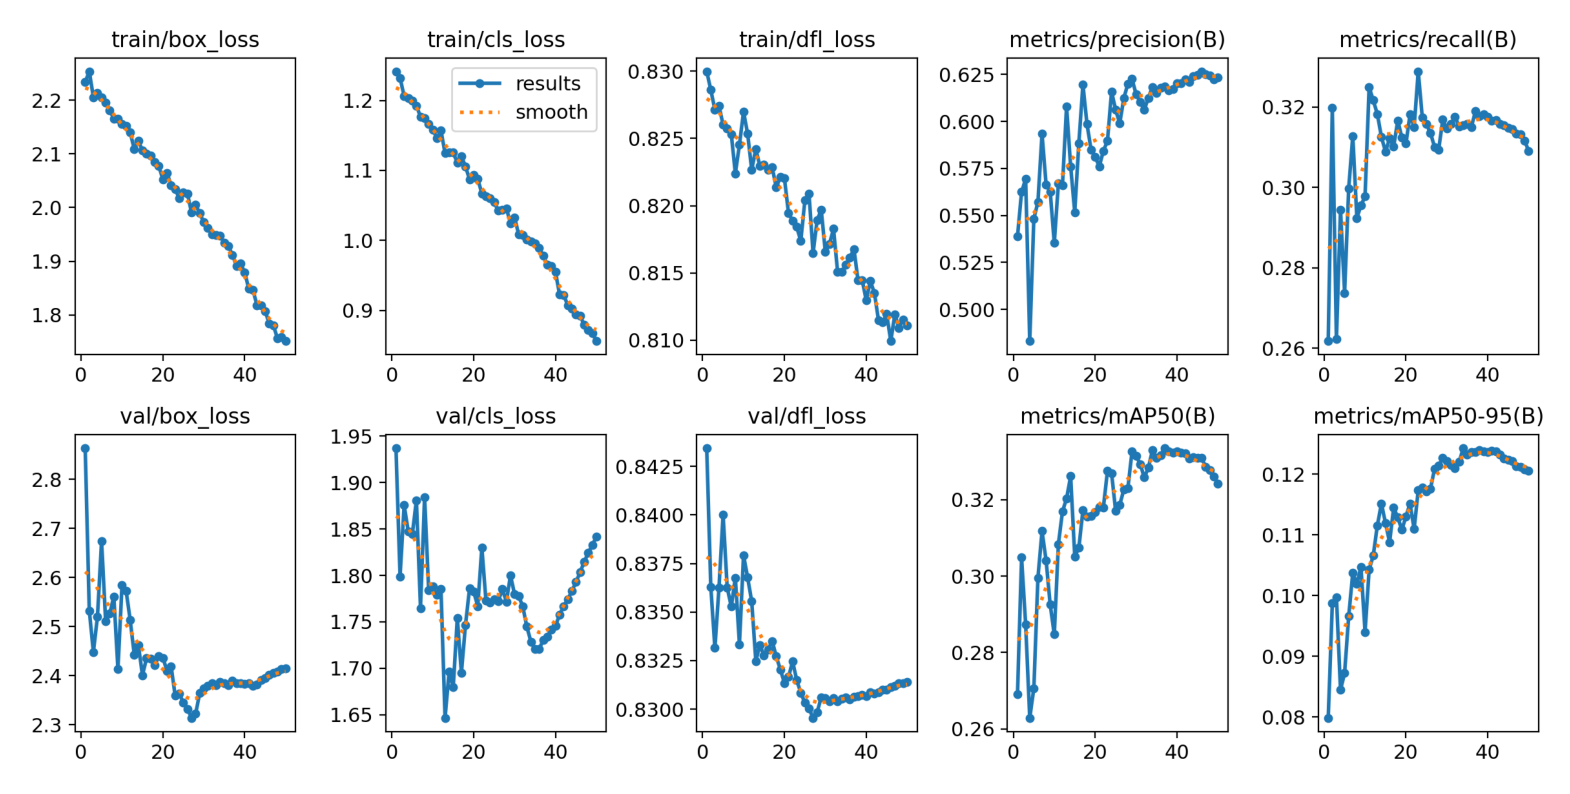

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,20)

plt.imread('yolov8n_project/tune_run_22/results.png')
plt.imshow(results)
plt.axis('off')
plt.show()

### Сохранение результатов

Сформируем короткое видео с результатами детекции

In [37]:
torch.cuda.empty_cache()
model = YOLO('yolov8n_project/tune_run_22/weights/best.pt')
challenge_pics_paths = sorted(glob(f'{sc_raw_ds_path}/challenge/SNMOT-021/img1/*'))

fourcc = cv2.VideoWriter_fourcc(*'XVID') 
w, h = 1920, 1080
fps = 25
video = cv2.VideoWriter('detection.avi', fourcc, fps, (w, h))

for i, pic in tqdm(enumerate(challenge_pics_paths[300:500])):
    results = model.predict(pic, verbose=False)
    ann_pic = results[0].plot()
    video.write(ann_pic)

cv2.destroyAllWindows()
video.release()

200it [00:03, 51.58it/s]
